In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `D:\xuexi_master\16745\lecture-notebooks\Lecture 12\Project.toml`


In [3]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using StaticArrays
using TrajOptPlots
const MOI = MathOptInterface;

In [4]:
    # Muscle parameters
    Eref = 0.04;
    c = 0.05;
    w = 0.56;
    # Individual muscle parameters
    r_flex = 0.08; qref_flex = 160*pi/180; lslack_flex = 0.1; lopt_flex = 0.11; lref_flex = lslack_flex + lopt_flex; vmax_flex = -12; Fmax_flex = 4000; #hfl
    r_ex = 0.08; qref_ex = 120*pi/180; lslack_ex = 0.13; lopt_ex = 0.11; lref_ex = lslack_ex +lopt_ex; vmax_ex = -12; Fmax_ex = 6000; #glu

In [5]:

"""
    Acrobot{T}

A double-pendulum with actuation only at the elbow joint. It has 4 states and 1 control.

# Constructor
    Acrobot(; kwargs...)

with keyword arguments:
* `l` - `SVector{2,T}` of link lengths
* `m` - `SVector{2,T}` of link masses
* `J` - `SVector{2,T}` of link inertias
""" 

struct Acrobot{T} <: AbstractModel
    l::SVector{2,T}
    m::SVector{2,T}
    J::SVector{2,T}
end

function Acrobot(l, m, J)
    #println(l)
    T = promote_type(eltype(l), eltype(m), eltype(J)) 
    Acrobot{T}(SA[l[1],l[2]], SA[m[1],m[2]], SA[J[1],J[2]])
    
end

function dynamics(model::Acrobot, x, u, v, fse_sq)
    g = 9.81
    m1,m2 = model.m
    l1,l2 = model.l
    J1,J2 = model.J
    θ1,    θ2    = x[1], x[2] #joint angles
    Lce_flex,Lce_ex  = x[3], x[4] #contractile element length
    A_flex, A_ex = x[5], x[6] #Activation
    θ1dot, θ2dot = x[7], x[8] #joint velocities
    stim1, stim2 = u[1], u[2]
    v_flex, v_ex = v[1], v[2]
    Fse_flex, Fse_ex = fse_sq[1], fse_sq[2]
    
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    c12 = cos(θ1 + θ2)

    # Muscle force [F]
    Fmtc_flex = Fse_flex*Fmax_flex
    Fmtc_ex = Fse_ex*Fmax_ex

    
    # Muscle velocity
    Lce_dot_flex = v_flex*vmax_flex*lopt_flex
    Lce_dot_ex = v_ex*vmax_ex*lopt_ex
    
    # Activation dot
    A_flex_dot = 100*(stim1-A_flex)
    A_ex_dot = 100*(stim2-A_ex)
    
    # Joint torque
    tau = Fmtc_flex*r_flex - Fmtc_ex*r_ex
    # mass matrix
    m11 = m1*l1^2 + J1 + m2*(l1^2 + l2^2 + 2*l1*l2*c2) + J2
    m12 = m2*(l2^2 + l1*l2*c2 + J2)
    m22 = l2^2*m2 + J2
    M = @SMatrix [m11 m12; m12 m22]

    # bias term
    tmp = l1*l2*m2*s2
    b1 = -(2 * θ1dot * θ2dot + θ2dot^2)*tmp
    b2 = tmp * θ1dot^2
    B = @SVector [b1, b2]

    # friction
    c = 1.0
    C = @SVector [c*θ1dot, c*θ2dot]

    # gravity term
    g1 = ((m1 + m2)*l2*c1 + m2*l2*c12) * g
    g2 = m2*l2*c12*g
    G = @SVector [g1, g2]

    # equations of motion
    τ = @SVector [0, tau]
    θddot = M\(τ - B - G - C)
    return @SVector [θ1dot, θ2dot, Lce_dot_flex, Lce_dot_ex, A_flex_dot, A_ex_dot, θddot[1], θddot[2]]
end

RobotDynamics.state_dim(::Acrobot) = 8
RobotDynamics.control_dim(::Acrobot) = 2

In [6]:
#Pendulum Dynamics
M_vec = @SVector [33.0, 17.0]
L_vec = @SVector [0.8, 1.0]
J_vec = @SVector [2.0, 2.0]
a = Acrobot(L_vec, M_vec, J_vec)
b = RobotZoo.Acrobot(L_vec, M_vec, J_vec)
h = 0.1 #10 Hz

0.1

In [8]:
Nx = 8     # number of state
Nu = 2     # number of controls
Np = 8     # number of parameters
Ns = 1     # number of slack variable
Tfinal = 12.0 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = (Nx+Nu+Np)*Nt + Ns# number of decision variables
m_nlp = Nx*(Nt+1) + Np*Nt + Ns

1945

In [9]:
#Equality constraints
function dircol_dynamics(x1,u1,x2,u2,v1,v2,fse_sq1,fse_sq2)
    #Hermite-Simpson integration with first-order hold on u
    f1 = dynamics(a, x1, u1, v1, fse_sq1)
    f2 = dynamics(a, x2, u2, v2, fse_sq2)
    xm = 0.5*(x1 + x2) + (h/8.0)*(f1 - f2)
    um = 0.5*(u1 + u2)
    vm = 0.5*(v1 + v2)
    fsem = 0.5*(fse_sq1+fse_sq2)
    ẋm = (-3/(2.0*h))*(x1 - x2) - 0.25*(f1 + f2)
    fm = dynamics(a, xm, um, vm, fsem)
    return fm - ẋm
end

function g1(x, fse_sq, fpe_sq)
    Lce_flex,Lce_ex  = x[3], x[4]
    fse_sq_flex, fse_sq_ex = fse_sq[1], fse_sq[2]
    fpe_sq_flex, fpe_sq_ex = fpe_sq[1], fpe_sq[2]
    
    Fse_flex = fse_sq_flex^2
    Fpe_flex = fpe_sq_flex^2
    Fce_flex = exp(log(c)*(1.8*((Lce_flex/lopt_flex-1)^2+0.01)/w)^(3/2))
    
    Fse_ex = fse_sq_ex^2
    Fpe_ex = fpe_sq_ex^2
    Fce_ex = exp(log(c)*(1.8*((Lce_ex/lopt_ex-1)^2+0.01)/w)^(3/2))
    
    return [(Fce_flex+Fpe_flex)-Fse_flex;(Fse_ex+Fpe_ex)-Fse_ex]
end

function g2(x,fse_sq)
    θ1,    θ2    = x[1], x[2] 
    Lce_flex,Lce_ex  = x[3], x[4]
    
    Lmtc_flex = -r_flex*(pi-θ2-qref_flex) + lref_flex
    Lse_flex = Lmtc_flex - Lce_flex
    Fse_flex_sq = (Lse_flex/lslack_flex-1)/Eref  
    
    Lmtc_ex = -r_ex*(pi-θ2-qref_ex) + lref_ex
    Lse_ex = Lmtc_ex - Lce_ex
    Fse_ex_sq = (Lse_ex/lslack_ex-1)/Eref
    return fse_sq - [Fse_flex_sq; Fse_ex_sq]
end

function g3(x,fse_sq,fpe_sq,fv)
    Lce_flex,Lce_ex  = x[3], x[4]
    A_flex, A_ex = x[5], x[6] 
    
    fse_sq_flex, fse_sq_ex = fse_sq[1], fse_sq[2]
    fpe_sq_flex, fpe_sq_ex = fpe_sq[1], fpe_sq[2]
    
    Fse_flex = fse_sq_flex^2
    Fpe_flex = fpe_sq_flex^2
    Fce_flex = exp(log(c)*(1.8*((Lce_flex/lopt_flex-1)^2+0.01)/w)^(3/2))
    
    Fse_ex = fse_sq_ex^2
    Fpe_ex = fpe_sq_ex^2
    Fce_ex = exp(log(c)*(1.8*((Lce_ex/lopt_ex-1)^2+0.01)/w)^(3/2))
    
    Fv_flex = Fse_flex/(A_flex*(Fce_flex+Fpe_flex+eps(1.0)))
    Fv_ex = Fse_ex/(A_ex*(Fce_ex+Fpe_ex+eps(1.0)))   
    fv_cal = [Fv_flex; Fv_ex]
    return fv - fv_cal
end

function g4(fv, v)
    Fv_flex, Fv_ex = fv[1], fv[2]
    
    v_flex = (0.07+lopt_flex)*(log((Fv_flex+eps(1.0))/3.5)-log(-(Fv_flex+eps(1.0))/1.501+1))
    v_ex = (0.07+lopt_ex)*(log((Fv_ex+eps(1.0))/3.5)-log(-(Fv_ex+eps(1.0))/1.501+1))
    v_cal = [v_flex; v_ex]
    return v - v_cal
end


g4 (generic function with 1 method)

In [10]:
# Cost weights
Q = Diagonal([5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0])
R = Diagonal(0.1*ones(2))

2×2 Diagonal{Float64, Vector{Float64}}:
 0.1   ⋅ 
  ⋅   0.1

In [11]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*u'*R*u
end

stage_cost (generic function with 1 method)

In [15]:
function cost(ztraj)
    z = reshape(ztraj[2:end],Nx+Nu+Np,Nt)
    J = 0.0
    for k = 1:Nt
        J += stage_cost(z[1:Nx,k],z[(Nx+1):(Nx+Nu),k])
    end
    J+= 0.5*ztraj[1]^2
    return J
end

cost (generic function with 1 method)

In [13]:
function dynamics_constraint!(c,ztraj)
    d = reshape(c,Nx,Nt-1)
    z = reshape(ztraj[2:end],Nx+Nu+Np,Nt)
    for k = 1:(Nt-1)
        x1 = z[1:Nx,k]
        u1 = z[(Nx+1):(Nx+Nu),k]
        v1 = z[(Nx+Nu+1):(Nx+Nu+2),k]
        fse_sq1 = z[(Nx+Nu+3):(Nx+Nu+4),k]
        x2 = z[1:Nx,k+1]
        u2 = z[(Nx+1):(Nx+Nu),k+1]
        v2 = z[(Nx+Nu+1):(Nx+Nu+2),k+1]
        fse_sq2 = z[(Nx+Nu+3):(Nx+Nu+4),k+1]
        d[:,k] = dircol_dynamics(x1,u1,x2,u2,v1,v2,fse_sq1,fse_sq2)
    end
    return nothing
end

function muscle_constraint!(c,ztraj)
    d = reshape(c,Np,Nt)
    z = reshape(ztraj[2:end],Nx+Nu+Np,Nt)
    for k = 1:Nt
        x = z[1:Nx,k]
        v = z[Nx+Nu+1:Nx+Nu+2,k]
        fse_sq = z[Nx+Nu+3:Nx+Nu+4,k]
        fpe_sq = z[Nx+Nu+5:Nx+Nu+6,k]
        fv = z[Nx+Nu+7:Nx+Nu+8,k]
        d[1:2,k] = g1(x, fse_sq, fpe_sq)
        d[3:4,k] = g2(x,fse_sq)
        d[5:6,k] = g3(x,fse_sq,fpe_sq,fv)
        d[7:8,k] = g4(fv, v)
    end
    return nothing
end

muscle_constraint! (generic function with 1 method)

In [27]:
function con!(c,ztraj)
    #println(size(c))
    z = reshape(ztraj[2:end],Nx+Nu+Np,Nt)
    c[1] = 0
    c[2:3] .= z[1:2,1] - x0[1:2] + [0; ztraj[1]]
    c[4:7] .= 0
    c[8:9] .= z[7:8,1] - x0[7:8]
    #println((Nx+1):(Nt-1)*Nx)
    @views dynamics_constraint!(c[(Nx+2):Nt*Nx+1],ztraj)
    c[Nt*Nx+2:Nx+Nt*Nx+1] .= z[1:Nx,end] - xgoal
    c[Nt*Nx+4:7+Nt*Nx] .= 0
    @views muscle_constraint!(c[Nx+Nt*Nx+2:end],ztraj)
end

con! (generic function with 1 method)

In [28]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    x_l[1] = 0.0
    x_u[1] = pi/2
    for k = 1:Nt
        x_l[(k-1)*(Nx+Nu+Np).+(3:7)] = [-50*pi/180, 0.01, 0.01, 0.01, 0.01]
        x_u[(k-1)*(Nx+Nu+Np).+(3:7)] = [160*pi/180, 0.4, 0.6, 1.0, 1.0]
        x_l[(k-1)*(Nx+Nu+Np).+(10:Nx+Nu+Np+1)] = [0.01, 0.01, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        x_u[(k-1)*(Nx+Nu+Np).+(10:Nx+Nu+Np+1)] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5]
    end
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_u = zeros(m)
        
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac
MOI.Silent() = true

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=Inf,c_tol=1.0e-1,max_iter=200)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        #xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, x[i], MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, x[i], MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end
    
    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

In [29]:
#Initial and goal states
x0 = [-pi/2; 0; 0.15; 0.15; 0.01; 0.01; 0; 0]
u0 =[0.01; 0.01]
#dynamics(a, x0, u0)
xgoal = [pi/2; 0; 0.15; 0.15; 0.01; 0.01; 0; 0]
xdiff = (xgoal - x0)/(Nt-1)
xtraj = [[0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0] for k = 1:Nt]
xtraj[1] = x0
for k = 1:Nt-1
    xtraj[k+1] = xtraj[k] + xdiff
end
xtraj= reduce(hcat,xtraj)
println(size(xtraj))

(8, 121)


In [30]:
#Guess
xguess = kron(ones(Nt)', x0)
xguess[1,:] .= xtraj[1,:] + 0.15*randn(Nt)
uguess = [[0.0; 0.0] for k = 1:Nt] #zeros(Nt)'
uguess = reduce(hcat,uguess)
vguess =  [[0.5; 0.5] for k = 1:Nt]
fseguess = [[0.5; 0.5] for k = 1:Nt]
fpeguess = [[0.5; 0.5] for k = 1:Nt]
fvguess = [[1.0; 1.0] for k = 1:Nt]
vguess = reduce(hcat,vguess)
fseguess = reduce(hcat,fseguess)
fpeguess = reduce(hcat,fpeguess)
fvguess = reduce(hcat,fvguess)
Δθ = pi/4;
println(size(xguess))
println(size(uguess))
println(size(vguess))
println(size(fseguess))
println(size(fpeguess))
println(size(fvguess))
z0 = [Δθ;reshape([xguess; uguess;vguess;fseguess;fpeguess;fvguess],(Nx+Nu+Np)*Nt,1)];
println(size(z0))

(8, 121)
(2, 121)
(2, 121)
(2, 121)
(2, 121)
(2, 121)
(2179, 1)


In [31]:
r_flex = 0.08; qref_flex = 160*pi/180; lslack_flex = 0.1; lopt_flex = 0.11; lref_flex = lslack_flex + lopt_flex; vmax_flex = -12; Fmax_flex = 4000; #hfl + rf
r_ex = 0.08; qref_ex = 120*pi/180; lslack_ex = 0.13; lopt_ex = 0.11; lref_ex = lslack_ex +lopt_ex; vmax_ex = -12; Fmax_ex = 6000; #glu + ham

In [33]:
prob = ProblemMOI(n_nlp,m_nlp)
z_sol = solve(z0,prob) # solve
ztraj = reshape(z_sol[2:end],Nx+Nu+Np,Nt);


In [34]:
xtraj = ztraj[1:Nx,:]
utraj = ztraj[(Nx+1):(Nx+Nu),:]
vtraj = ztraj[(Nx+Nu+1):(Nx+Nu+2),:]
fsetraj = ztraj[(Nx+Nu+3):(Nx+Nu+4),:]
fpetraj = ztraj[(Nx+Nu+5):(Nx+Nu+6),:]
fvtraj = ztraj[(Nx+Nu+7):(Nx+Nu+8),:];

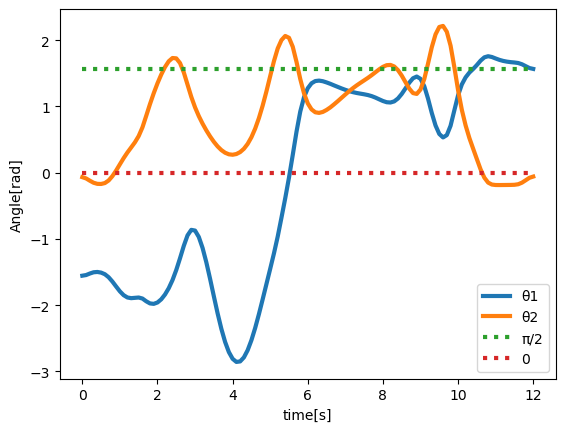

121-element Vector{Float64}:
 -0.06779630863326719
 -0.08672590148733822
 -0.12110052031446887
 -0.1520059641900658
 -0.16850950778420332
 -0.17033163635964865
 -0.15660364654065864
 -0.11781738448558464
 -0.05252432426192388
  0.032494327581783396
  0.12697417086216187
  0.21996858781689982
  0.30463321347401334
  ⋮
 -0.17910141236229238
 -0.18605387626272693
 -0.18663876622389838
 -0.186077000232347
 -0.18547879961262828
 -0.1847629463060742
 -0.18278249937297983
 -0.17451542284769112
 -0.15080731553679388
 -0.11401257893485021
 -0.07683427435089565
 -0.05870067697827518

In [23]:
plot(thist,xtraj[1,:],lw=3)
plot(thist,xtraj[2,:],lw=3)
plot(thist,pi/2*ones(Nt),linestyle=":",lw=3)
plot(thist,0*ones(Nt),linestyle=":",lw=3)
xlabel("time[s]")
ylabel("Angle[rad]")
legend(["θ1","θ2","π/2","0"])
xtraj[2,:]

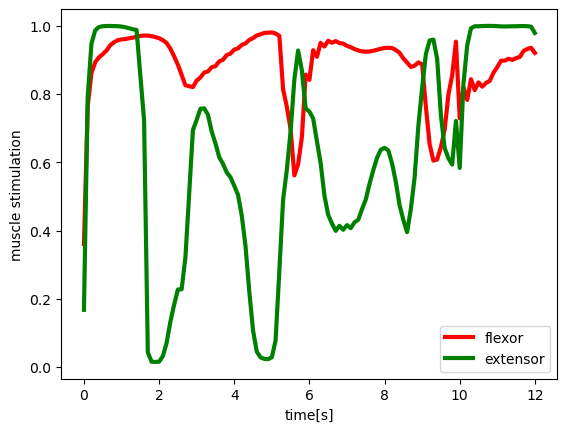

PyObject <matplotlib.legend.Legend object at 0x00000000025B6C40>

In [24]:
plot(thist,utraj[1,:], color="red", lw=3)
plot(thist,utraj[2,:], color="green", lw=3)
xlabel("time[s]")
ylabel("muscle stimulation")
legend(["flexor","extensor"])

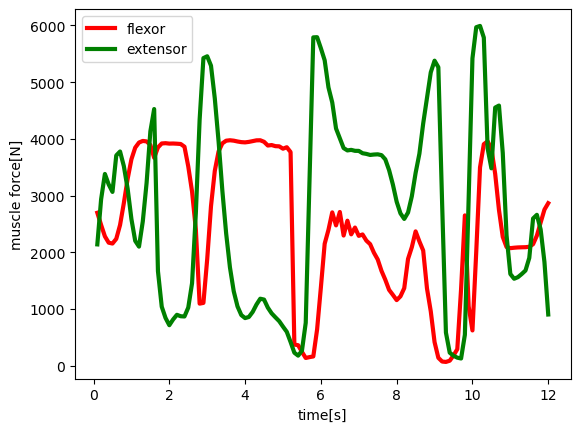

(2, 121)


PyObject <matplotlib.legend.Legend object at 0x0000000062A58550>

In [25]:
Ftraj = fsetraj
println(size(Ftraj))
plot(thist[2:end],Ftraj[1,2:end]*4000, color="red", lw=3)
plot(thist[2:end],Ftraj[2,2:end]*6000, color="green", lw=3)
xlabel("time[s]")
ylabel("muscle force[N]")
legend(["flexor","extensor"])

In [36]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\Shi Yuyao\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [37]:
TrajOptPlots.set_mesh!(vis, b)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8700

In [38]:
X1 = [SVector{4}([x[1:2]; x[7:8]]) for x in eachcol(xtraj)];
visualize!(vis, b, thist[end], X1)